#### 패키지 Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense

#### 전역변수 설정

In [2]:
trainGraphTitle = "Train Data"
testGraphTitle = "Test Data"
loss = "mse" # mse

resultComment = "result"
fileSavePath = "./result"

depth = "SingleGRU" # Default
# depth = "DoubleGRU" 
# depth = "TripleGRU"

# 변수 "" 가 Default
hiddenState = 32 # units: 16 "32" 64
timeStep = 20 # input_length 10 "20" 40
activation = "tanh" # "tanh" sigmoid
epochs = 100 # 50 "100" 200
batchSize = 64 # 32 "64" 256
dataSetYear = 10 # 5 "10" 40
optimizer = "adam" # "adam" sgd

#### Pandas Setting

In [3]:
pd.set_option('display.max_rows', None) # row 생략 없이 출력
pd.set_option('display.max_columns', None) # col 생략 없이 출력

#### Data Load

In [4]:
apple = pd.read_csv("Apple_5Y.csv")

if dataSetYear == 10:
    apple = pd.read_csv("Apple_10Y.csv")
elif dataSetYear == 40:
    apple = pd.read_csv("Apple_Whole_Period.csv")

#### Describe 확인

In [5]:
apple.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2.518000e+03
mean,62.383387,63.087693,61.696664,62.416599,60.637030,1.713540e+08
std,48.683035,49.322128,48.051043,48.709794,49.248659,1.250498e+08
min,13.856071,14.271429,13.753571,13.947500,12.064585,3.519590e+07
25%,26.971249,27.219376,26.705000,26.983750,24.676634,9.188698e+07
50%,41.353750,41.872500,40.888750,41.313750,39.511671,1.301368e+08
75%,91.272499,92.881876,90.824377,91.526875,90.122925,2.045116e+08
max,182.630005,182.940002,179.119995,182.009995,180.959732,1.460852e+09


#### trainData, testData 가공하는 함수

In [6]:
def transformData(data: [[float]]):
    # 날짜 제외
    data = data.drop(columns=["Date"])

    # 데이터 분리 test: 200개와 나머지
    trainSet = data[ : -200]
    testSet = data[-200 : ]
    
    # 데이터 0~1로 정규화
    sc = MinMaxScaler(feature_range=(0, 1)) 
    sc.fit(trainSet)
    trainSet = sc.transform(trainSet)
    testSet = sc.transform(testSet)
    
    # trainX, trainY, testX, testY 분리
    def parsingData(dataSet: [[float]]) -> ([[[float]]], [[float]]):
        dataX, dataY = [], []
        for index in range(len(dataSet) - timeStep):
            temp = []
            for step in range(timeStep):
                temp.append(dataSet[index + step])
            dataX.append(temp)
            dataY.append(dataSet[index + timeStep])

        return np.array(dataX), np.array(dataY)

    trainDataX, trainDataY = parsingData(trainSet)
    testDataX, testDataY = parsingData(testSet)
    
    
    return trainDataX, trainDataY, testDataX[:-30], testDataY, sc

#### Data Parsing

In [7]:
trainX, trainY, testX, testY, scaler = transformData(apple)

#### Model Implementation

In [8]:
model = Sequential()

if depth == "TripleGRU":
    model.add(
        GRU(
            units = hiddenState,
            input_length = trainX.shape[1],
            input_dim = trainX.shape[2],
            activation = activation,
            return_sequences = True
        )
    )
    model.add(
        GRU(
            units = hiddenState,
            activation = activation,
            return_sequences = True
        )
    )
    model.add(
        GRU(
            units = hiddenState,
            activation = activation
        )
    )
    
    model.add(Dense(6))
    
elif depth == "DoubleGRU":
    model.add(
        GRU(
            units = hiddenState,
            input_length = trainX.shape[1],
            input_dim = trainX.shape[2],
            activation = activation,
            return_sequences = True
        )
    )
    model.add(
        GRU(
            units = hiddenState,
            activation = activation
        )
    )
    
    model.add(Dense(6))
elif depth == "SingleGRU":
    model.add(
    GRU(
        units = hiddenState,
        input_length = trainX.shape[1],
        input_dim = trainX.shape[2],
        activation = activation
        )
    )
    model.add(Dense(6))

model.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 16)                1152      
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
Total params: 1,254
Trainable params: 1,254
Non-trainable params: 0
_________________________________________________________________


2023-01-05 01:51:39.273651: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-05 01:51:39.273747: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Model Complie

In [9]:
model.compile(
    loss = loss,
    optimizer = optimizer,
    metrics = ["mae"]
)

#### Model Training

In [10]:
fitStartTime = time.time()
history = model.fit(
    trainX,
    trainY,
    epochs = epochs,
    batch_size = batchSize
)
fitEndTime = time.time()

Epoch 1/100


2023-01-05 01:51:39.491945: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 01:51:40.102810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-05 01:51:40.195881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 6/36 [====>.........................] - ETA: 0s - loss: 0.1317 - mae: 0.2330 

2023-01-05 01:51:40.304866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 1s 13ms/step - loss: 0.0771 - mae: 0.1720
Epoch 2/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0189 - mae: 0.0928
Epoch 3/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0056 - mae: 0.0581
Epoch 4/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0325
Epoch 5/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0015 - mae: 0.0257
Epoch 6/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0013 - mae: 0.0238
Epoch 7/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0012 - mae: 0.0221
Epoch 8/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0011 - mae: 0.0211
Epoch 9/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0010 - mae: 0.0199
Epoch 10/100
36/36 [==============================] - 0s 10ms/step - loss: 9.4087e-04 - mae: 0.0192
Epoch 11/100
36/36 [==============================] - 0s 

36/36 [==============================] - 0s 11ms/step - loss: 4.6072e-04 - mae: 0.0099
Epoch 84/100
36/36 [==============================] - 0s 12ms/step - loss: 4.6013e-04 - mae: 0.0099
Epoch 85/100
36/36 [==============================] - 0s 11ms/step - loss: 4.5958e-04 - mae: 0.0099
Epoch 86/100
36/36 [==============================] - 0s 10ms/step - loss: 4.6015e-04 - mae: 0.0099
Epoch 87/100
36/36 [==============================] - 0s 11ms/step - loss: 4.6258e-04 - mae: 0.0099
Epoch 88/100
36/36 [==============================] - 0s 10ms/step - loss: 4.5963e-04 - mae: 0.0099
Epoch 89/100
36/36 [==============================] - 0s 10ms/step - loss: 4.5888e-04 - mae: 0.0098
Epoch 90/100
36/36 [==============================] - 0s 11ms/step - loss: 4.5869e-04 - mae: 0.0099
Epoch 91/100
36/36 [==============================] - 0s 11ms/step - loss: 4.6109e-04 - mae: 0.0099
Epoch 92/100
36/36 [==============================] - 0s 11ms/step - loss: 4.5842e-04 - mae: 0.0098
Epoch 93/100


#### 시간 및 평가 기록

In [11]:
fitTime = fitEndTime - fitStartTime
score = model.evaluate(testX, testY[:-30])

f = open("result.txt", "a")
f.write(f"{resultComment}\n모델 학습 시간: {fitTime:.3} sec\n평가 손실: {score[0]}\n\n")
f.close()

5/5 [==============================] - 0s 16ms/step - loss: 6.2097e-04 - mae: 0.0196


2023-01-05 01:52:18.602361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-05 01:52:18.638804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [12]:
f"모델 학습 시간: {fitTime:.3} sec"

'모델 학습 시간: 39.0 sec'

In [13]:
f"평가 손실: {score[0]}"

'평가 손실: 0.0006209673592820764'

#### 예측

In [14]:
trainPrediction = scaler.inverse_transform(model.predict(trainX))
testPrediction = scaler.inverse_transform(model.predict(testX))

inversingTrainY = scaler.inverse_transform(trainY)
inversingTestY = scaler.inverse_transform(testY)

27/72 [==========>...................] - ETA: 0s

2023-01-05 01:52:18.897790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-05 01:52:18.924723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 11ms/step


### 그래프

#### Loss

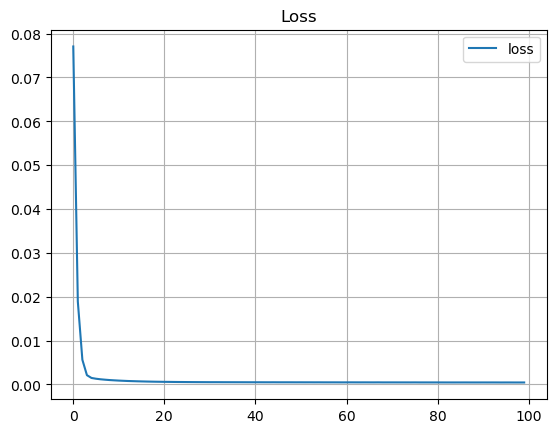

In [15]:
loss = history.history["loss"]
plt.title("Loss")
plt.plot(loss, label="loss")
plt.grid(True)
plt.savefig(f"{fileSavePath}/Loss.png")
plt.legend()
plt.show()

#### Train Data Graph

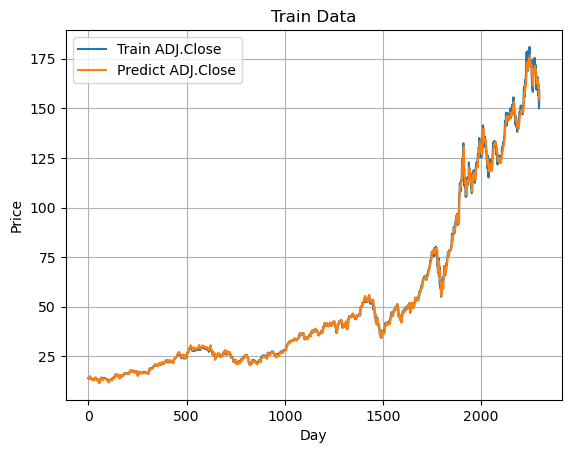

In [16]:
plt.title(trainGraphTitle)
plt.plot(inversingTrainY[:, 4], label="Train ADJ.Close")
plt.plot(trainPrediction[:, 4], label="Predict ADJ.Close")
plt.grid(True)
plt.savefig(f"{fileSavePath}/Train.png")
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

#### Test Data Graph

In [17]:
# plt.title(testGraphTitle)
# plt.plot(inversingTestY[:, 4], label="Test ADJ.Close")
# plt.plot(testPrediction[:, 4], label="Predict ADJ.Close")
# plt.grid(True)
# plt.xlabel('Day')
# plt.ylabel('Price')
# plt.axvline(x=len(testY)-30, color='green', linestyle='-', linewidth=1)
# plt.legend()
# plt.savefig(f"{fileSavePath}/Test.png")
# plt.show()

#### Test Data + 30일 후 예측

In [18]:
for _ in range(30):
    nextPredict = model.predict(testX)
    newData = nextPredict[-timeStep:]
    newData = np.reshape(newData, (1, newData.shape[0], newData.shape[1]))
    testX = np.append(testX, newData, axis = 0)

6/6 [==============================] - 0s 10ms/step


#### Test Data + 30일 예측 그래프

6/6 [==============================] - 0s 10ms/step


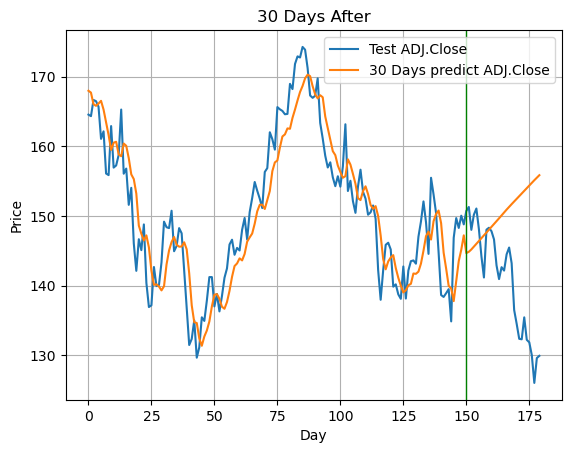

In [19]:
ThirtyDaysAfterpredict = scaler.inverse_transform(model.predict(testX))

plt.title("30 Days After")
plt.plot(inversingTestY[:, 4], label="Test ADJ.Close")
plt.plot(ThirtyDaysAfterpredict[:, 4], label="30 Days predict ADJ.Close")
plt.grid(True)
plt.xlabel('Day')
plt.ylabel('Price')
plt.axvline(x=len(testY)-30, color='green', linestyle='-', linewidth=1)
plt.legend()
plt.savefig(f"{fileSavePath}/30Predict.png")
plt.show()